# Jores et al 2021 Intepretation
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to interpret the best trained models on the Jores et al (2021) dataset.
***

In [7]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# For illustrator purposes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [9]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/jores21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/jores21"
eu.settings.figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/jores21"

# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [49]:
# Load in the preprocessed training data
sdata_leaf = eu.dl.read(os.path.join(eu.settings.output_dir, "leaf_test_predictions.h5sd"))
sdata_proto = eu.dl.read(os.path.join(eu.settings.output_dir, "proto_test_predictions.h5sd"))
#sdata_combined = eu.dl.read(os.path.join(eu.settings.output_dir, "combined_test_predictions.h5sd"))
#sdata_leaf, sdata_proto, sdata_combined

# Load the best model

In [47]:
leaf_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "ssHybrid", f"leaf_trial_5", "checkpoints", "*"))[0]
leaf_model = eu.models.Hybrid.load_from_checkpoint(leaf_model_file)
proto_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "Jores21CNN", f"proto_trial_2", "checkpoints", "*"))[0]
proto_model = eu.models.Jores21CNN.load_from_checkpoint(proto_model_file)
#combined_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "Jores21CNN", f"combined_trial_3", "checkpoints", "*"))[0]
#combined_model = eu.models.Jores21CNN.load_from_checkpoint(combined_model_file)

In [58]:
# Choose which model you want to intepret
name = "proto"
model = proto_model
sdata = sdata_proto

# Feature attribution

In [51]:
# Run three saliency feature attribution methods across all sequences
saliency_methods = ["InputXGradient", "DeepLift", "GradientSHAP"]
for method in saliency_methods:
    eu.interpret.feature_attribution_sdata(
        model=model,
        sdata=sdata,
        method=method
    )

False
No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/59 [00:00<?, ?it/s]

False
No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/59 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


False
No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/59 [00:00<?, ?it/s]

Importance values: 0it [00:00, ?it/s]

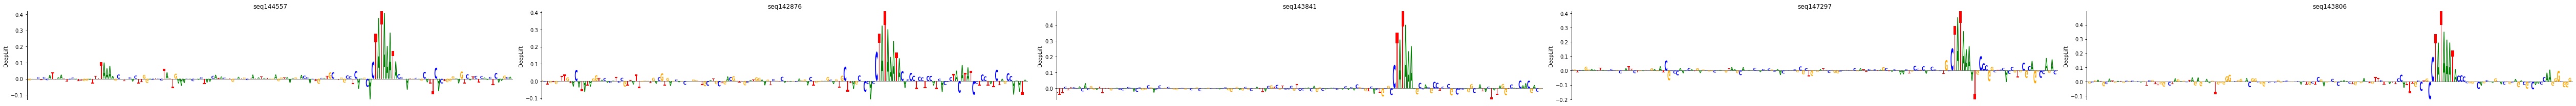

Importance values: 0it [00:00, ?it/s]

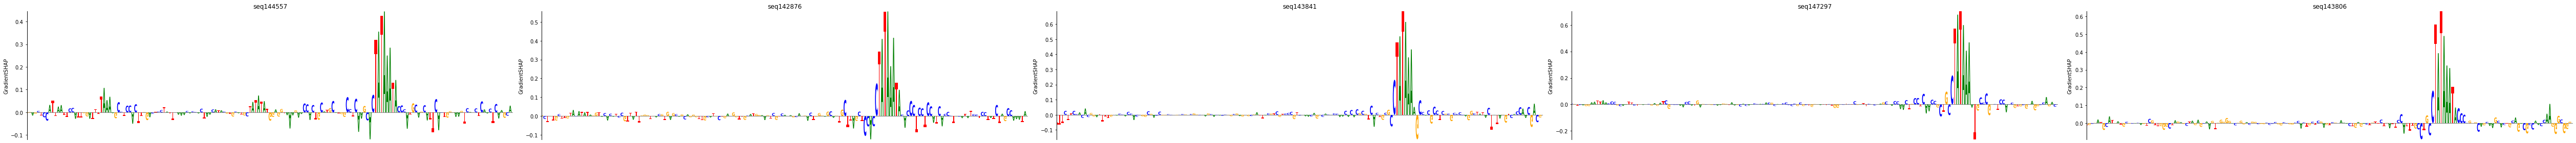

In [52]:
# Grab the top10 in terms of predictions to plot tracks for
top5 = sdata["ssHybrid_trial_5_enrichment_predictions"].sort_values(ascending=False).iloc[:5].index

eu.pl.lm_multiseq_track(
    sdata,
    seq_ids=top5,
    uns_keys = "DeepLift_imps",
    ylabels="DeepLift",
    height=3,
    width=70,
    save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_feature_attr.pdf")
)

# Filter viz

In [55]:
# Generate pfms from filters using method described in Minnoye et al. 2020
eu.interpret.generate_pfms_sdata(
    model=model, 
    sdata=sdata,
    method="Minnoye20"
)

No transforms given, assuming just need to tensorize.


Getting maximial activating seqlets:   0%|          | 0/59 [00:00<?, ?it/s]

['A', 'C', 'G', 'T']


Getting PFMs from filters:   0%|          | 0/256 [00:00<?, ?it/s]

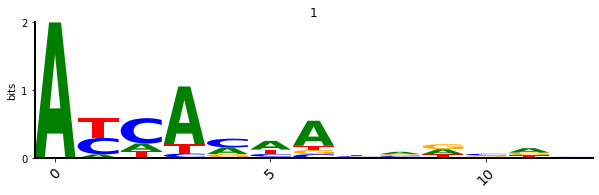

In [56]:
# Visualize a filter of choice
eu.pl.lm_filter_viz(
    sdata,
    filter_id=1
)

Plotting and saving filters 1-32
Plotting and saving filters 33-64
Plotting and saving filters 65-96
Plotting and saving filters 97-128
Plotting and saving filters 129-160
Plotting and saving filters 161-192
Plotting and saving filters 193-224
Plotting and saving filters 225-256


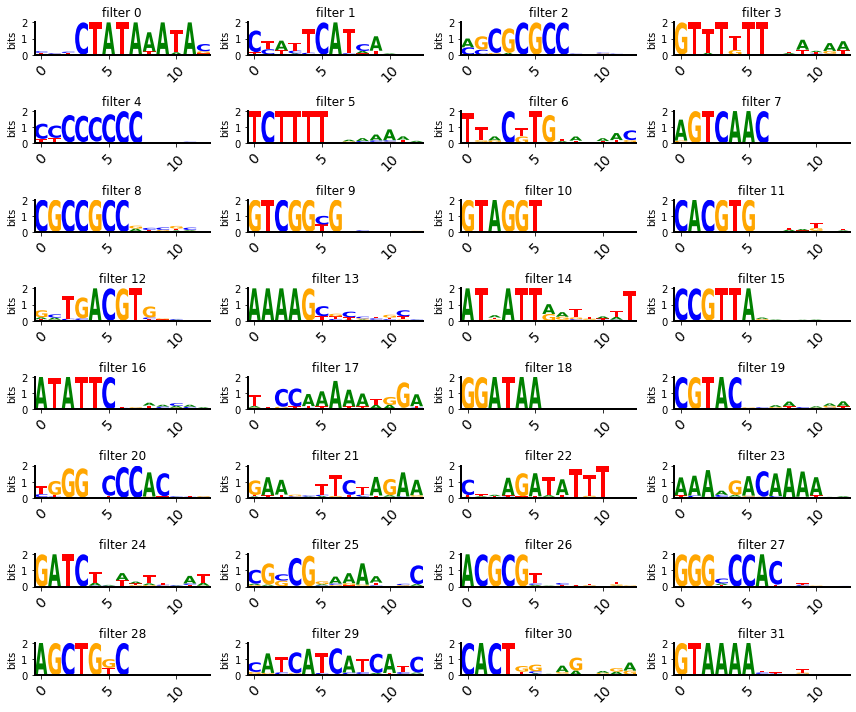

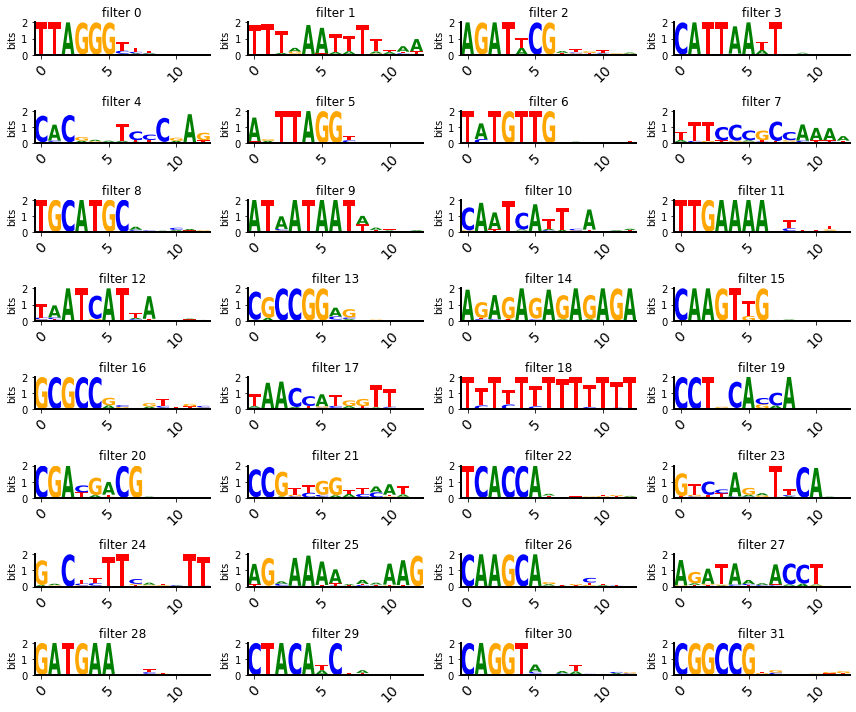

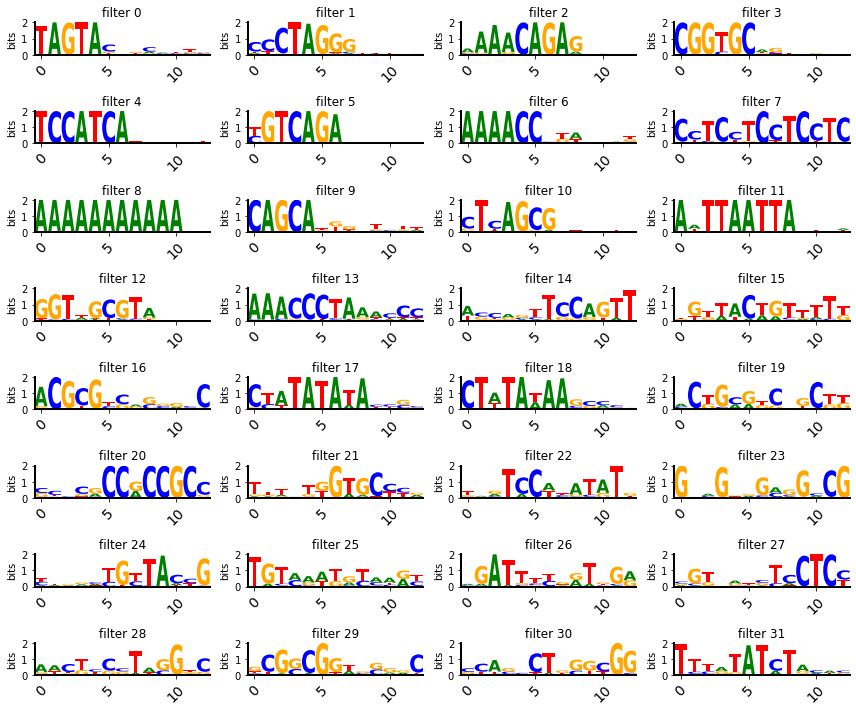

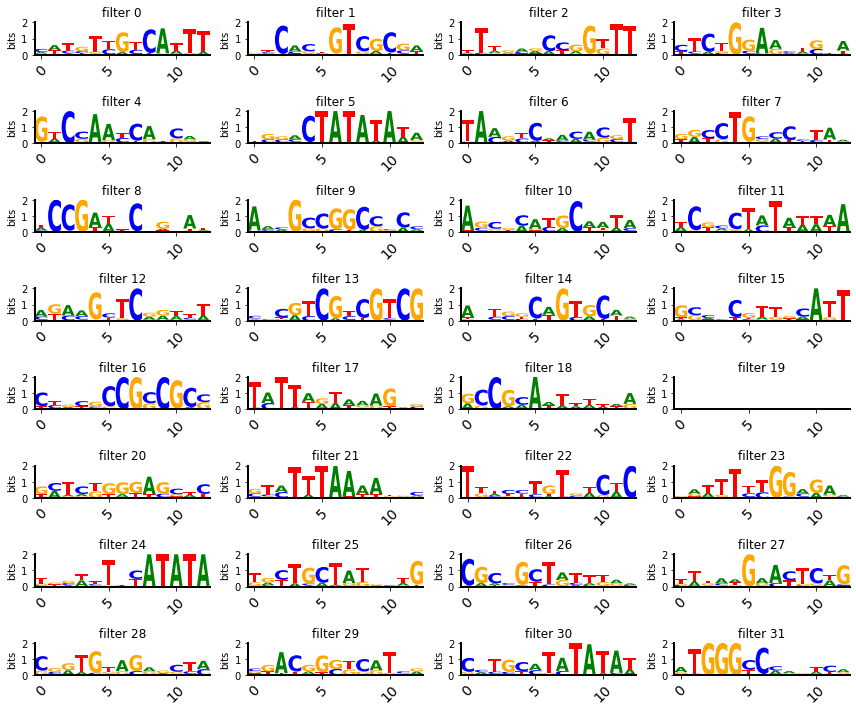

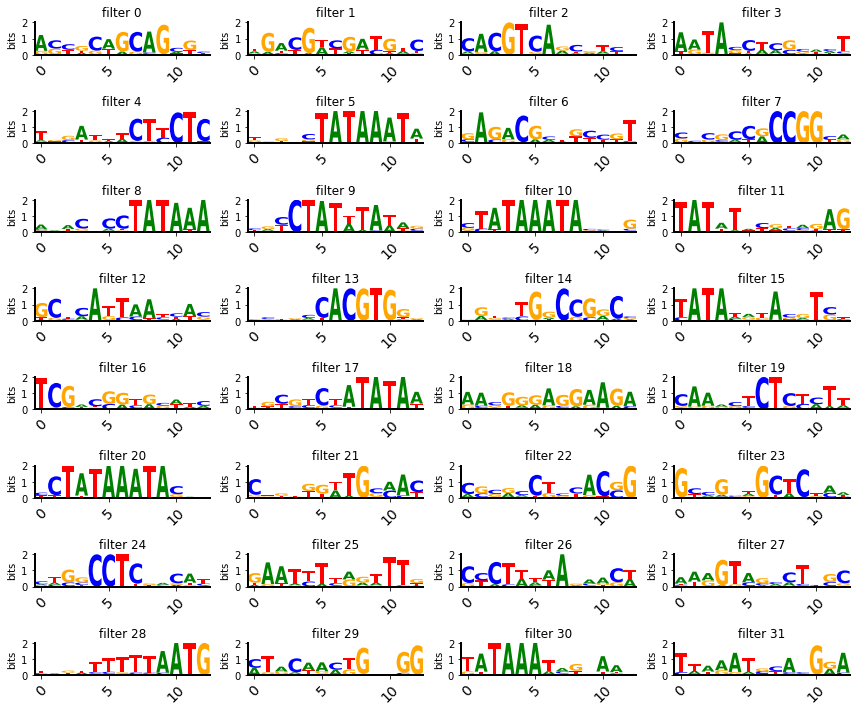

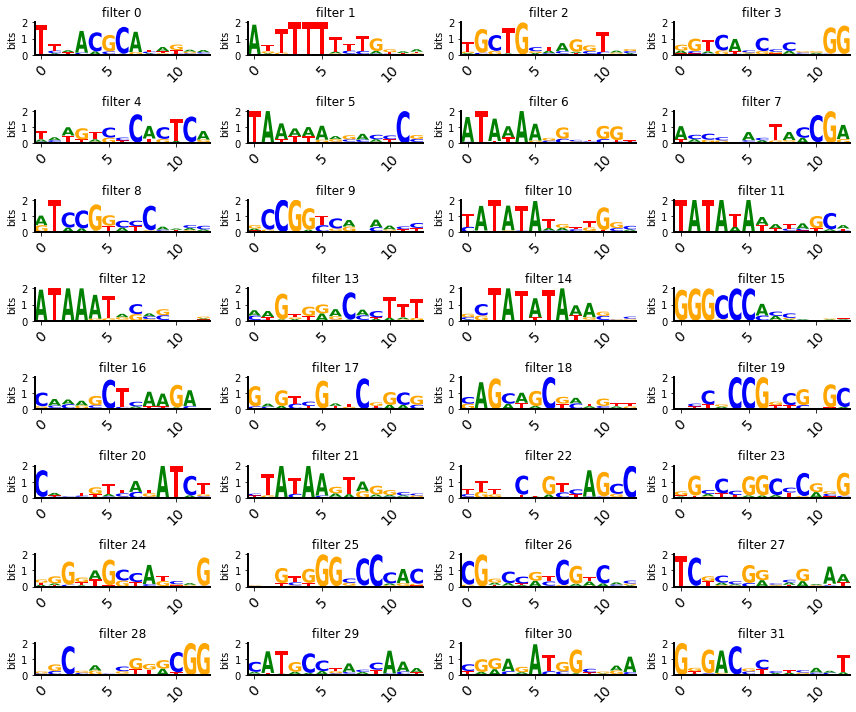

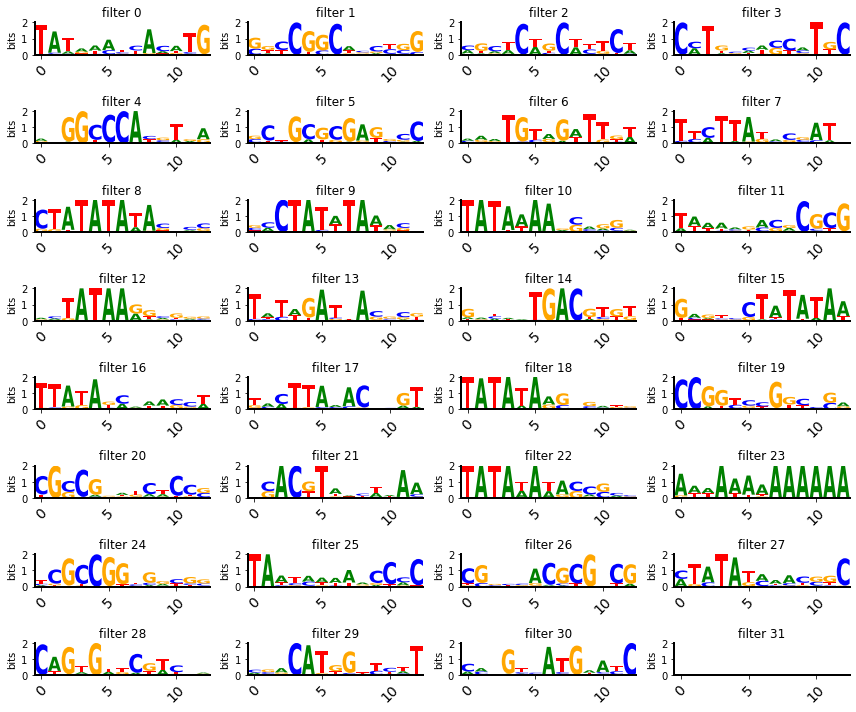

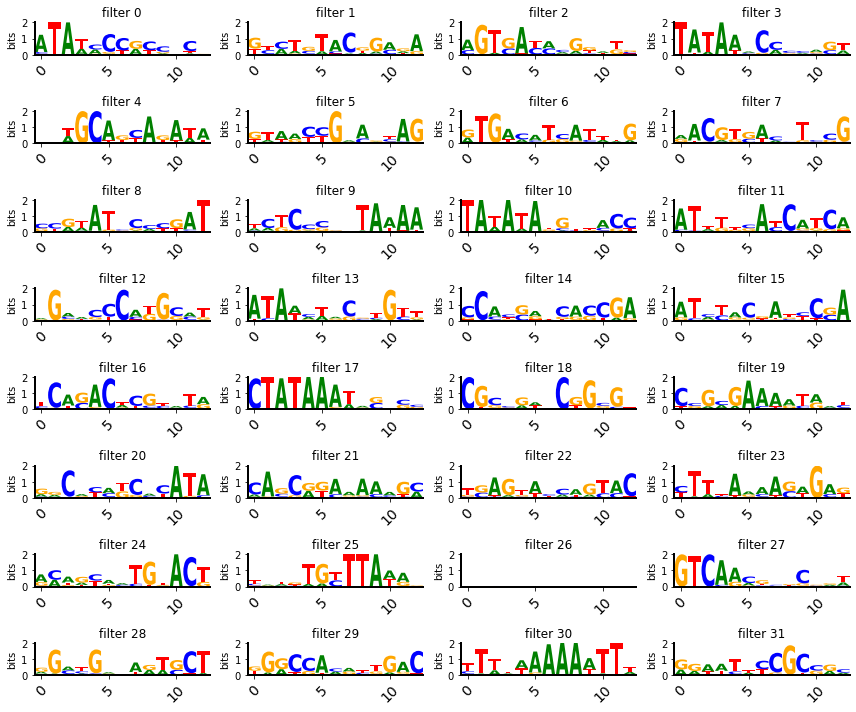

In [17]:
# Visualize multiple filters at once and save
for i in range(8):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    eu.pl.lm_multifilter_viz(
        sdata,
        filter_ids=list(sdata.uns["pfms"].keys())[start_filter:end_filter],
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(start_filter, end_filter)],
        save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_filters{start_filter+1}-{end_filter}_viz.pdf")
    )

In [59]:
# Save all the filter pfms from above as meme format for submission to TomTom
eu.dl.motif.filters_to_meme_sdata(
    sdata,
    filter_ids=list(sdata.uns["pfms"].keys()),
    output_dir=os.path.join(eu.settings.output_dir),
    file_name=f"{name}_best_model_filters.meme"
)

Saved PWM File as : /cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_best_model_filters.meme


In [60]:
sdata.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_test_predictions_and_interpretations.h5sd"))

## In silico evolution 

In [61]:
# Load in sequences that were evolved in the published paper
sdata_evolve = eu.dl.read_csv(os.path.join(eu.settings.dataset_dir, "promoters_for_evolution.tsv"), seq_col="sequence", name_col="name")
eu.pp.ohe_seqs_sdata(sdata_evolve)
sdata_evolve

One-hot encoding sequences:   0%|          | 0/310 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 310 ohe_seqs added


SeqData object with = 310 seqs
seqs = (310,)
names = (310,)
rev_seqs = None
ohe_seqs = (310, 4, 170)
ohe_rev_seqs = None
seqs_annot: 'target'
pos_annot: None
seqsm: None
uns: None

In [62]:
# Evolve them using the best model across 10 rounds
eu.interpret.evolve_seqs_sdata(
    model,
    sdata_evolve,
    rounds=10
)

Evolving seqs:   0%|          | 0/310 [00:00<?, ?it/s]

SeqData object modified:
    seqs_annot:
        + evolved_9_score, evolved_1_score, evolved_3_score, evolved_6_score, evolved_4_score, evolved_8_score, evolved_5_score, evolved_10_score, original_score, evolved_7_score, evolved_2_score


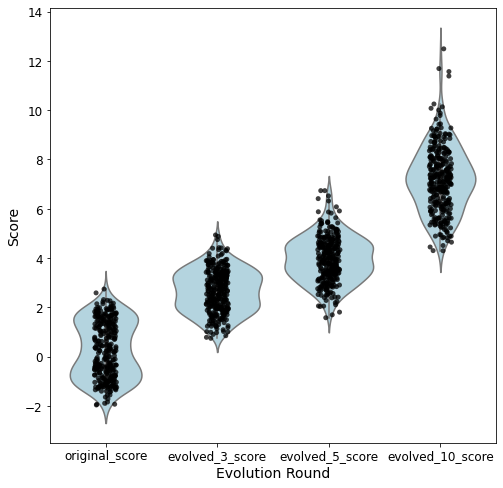

In [63]:
eu.pl.violinplot(
    sdata_evolve,
    groupby=["original_score", "evolved_3_score", "evolved_5_score", "evolved_10_score"],
    xlabel="Evolution Round",
    ylabel="Score",
    color = "lightblue",
    save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_evolution_summary.pdf")
)

In [64]:
sdata_evolve.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_evolved_sequences.h5sd")) 

# In silico feature implant

In [80]:
sdata_evolve.ohe_seqs.shape

(310, 4, 170)

In [70]:
# Prep feature from meme file
meme = eu.dl.motif.MinimalMEME(path=os.path.join(eu.settings.dataset_dir, "CPEs.meme"))
motif = meme.motifs["TATA"]
feat_name = motif.name
pfm = motif.pfm
uniform_pfm = np.zeros(pfm.shape) + 0.25
rand_pfm = np.random.normal(loc=0, scale=1, size=pfm.shape)
consensus = motif.consensus
name, pfm, consensus

('proto',
 array([[0.1275, 0.3765, 0.1195, 0.3765],
        [0.1575, 0.3985, 0.199 , 0.2455],
        [0.249 , 0.303 , 0.197 , 0.251 ],
        [0.1235, 0.655 , 0.0755, 0.1455],
        [0.01  , 0.002 , 0.002 , 0.986 ],
        [0.968 , 0.    , 0.    , 0.032 ],
        [0.002 , 0.014 , 0.006 , 0.978 ],
        [0.992 , 0.    , 0.002 , 0.006 ],
        [0.653 , 0.012 , 0.002 , 0.333 ],
        [0.974 , 0.    , 0.008 , 0.018 ],
        [0.341 , 0.028 , 0.036 , 0.5955],
        [0.6955, 0.0815, 0.1195, 0.1035],
        [0.1255, 0.432 , 0.3165, 0.1255],
        [0.291 , 0.418 , 0.175 , 0.1155],
        [0.263 , 0.3445, 0.1755, 0.2175],
        [0.307 , 0.3085, 0.2365, 0.1475]]),
 'CCCCTATAAATACCCC')

In [75]:
test = eu.pp.feature_implant_across_seq(
    seq=sdata_evolve.ohe_seqs[0],
    feature=rand_pfm,
    encoding="onehot",
    onehot=True
)

In [79]:
eu.pp.feature_implant_seq(
    seq=sdata_evolve.ohe_seqs[0],
    position=0,
    feature=rand_pfm,
    encoding="onehot",
    onehot=True
).shape

(4, 182)

In [76]:
test.shape

(167, 4, 182)

In [72]:
# Slide a random pfm across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=rand_pfm,
    seqsm_key=f"slide_random",
    encoding="onehot", 
    onehot=True
)
sdata_evolve.seqsm[f"slide_random"].shape

# Slide a uniform pfm across the sequences 
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=uniform_pfm,
    seqsm_key=f"slide_uniform",
    encoding="onehot", 
    onehot=True
)

# Slide the TATA motif across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=pfm, 
    seqsm_key=f"slide_{feat_name}",
    encoding="onehot", 
    onehot=True
)

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

torch.Size([167, 4, 182])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (167x46592 and 43520x64)

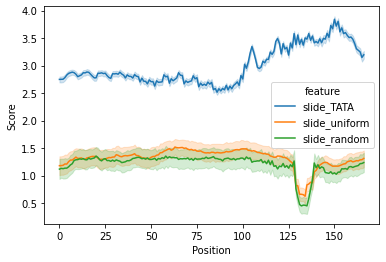

In [ ]:
eu.pl.feature_implant_plot(
    sdata_evolve,
    seqsm_keys=[f"slide_{feat_name}", f"slide_uniform", f"slide_random"],
    save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_feature_implant_TATA.pdf")
)

In [ ]:
sdata_evolve.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_evolved_sequences_with_TATA_implant.h5sd")) 

---

# Scratch